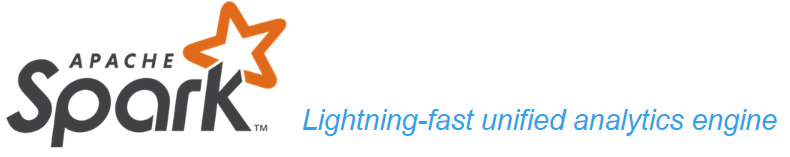

# ML Tuning: model selection and hyperparameter tuning

# <a href="http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.tuning">Model selection (a.k.a. hyperparameter tuning)</a>


An important task in ML is model selection. One of the common problem we have seen in ML model which does not perform well in production. Reason for that is ...

Our model doesn't generlized well from our trainng data to unseen data this is known as "Overfitting" problem

and opposite to that 

some times ...

when model is too simple and informed by too few features or regularized too much which makes inflixible learning from the data is call underfitting problme

To Prevent Overfitting and underfitting problem there are various techniques available and Hyperparameter tunning is one of the techniques. 

Very nice article on <a href="https://elitedatascience.com/overfitting-in-machine-learning" target=_blank>Overfitting in Machine Learning</a>


Model selection or using data to find the best model or parameters for a given task. This is also called tuning. Tuning may be done for individual Estimators such as LogisticRegression, or for entire Pipelines which include multiple algorithms, featurization, and other steps. Users can tune an entire Pipeline at once, rather than tuning each element in the Pipeline separately.

- MLlib supports model selection using tools such as CrossValidator and TrainValidationSplit. These tools require the following items:

- Estimator: algorithm or Pipeline to tune
- Set of ParamMaps: parameters to choose from, sometimes called a “parameter grid” to search over
- Evaluator: metric to measure how well a fitted Model does on held-out test data

At a high level, these model selection tools work as follows:

- They split the input data into separate training and test datasets.
- For each (training, test) pair, they iterate through the set of ParamMaps:
- For each ParamMap, they fit the Estimator using those parameters, get the fitted Model, and evaluate the Model’s performance using the Evaluator.
- They select the Model produced by the best-performing set of parameters.

The <a href="http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.evaluation">Evaluator</a> can be a RegressionEvaluator for regression problems, a BinaryClassificationEvaluator for binary data, or a MulticlassClassificationEvaluator for multiclass problems. The default metric used to choose the best ParamMap can be overridden by the setMetricName method in each of these evaluators.



# How to prevent overfitting 
Spark MLLib got <a href="http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.tuning">Model selection and Hyper parameter tunning module</a>. Please refer below URL for more details 



Though there are various techniques availble to prevent overfitting. Spark does support techniques called <a href="https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidatorModel">"Cross-Validation"</a> and <a href="https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.TrainValidationSplit">"Train-Validation Split"</a> out of box

This lecture focus on Cross-Validation and Train-Validation Split ML tunning module 

# <a href="https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidatorModel">Cross-validation</a>
CrossValidator begins by splitting the dataset into a set of folds which are used as separate training and test datasets. E.g., with k=3 folds, CrossValidator will generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing. To evaluate a particular ParamMap, CrossValidator computes the average evaluation metric for the 3 Models produced by fitting the Estimator on the 3 different (training, test) dataset pairs.

The following example demonstrates using CrossValidator to select from a grid of parameters.

Note that cross-validation over a grid of parameters is expensive. E.g., in the example below, the parameter grid has 3 values for hashingTF.numFeatures and 2 values for lr.regParam, and CrossValidator uses 2 folds. This multiplies out to (3×2)×2=12 different models being trained. In realistic settings, it can be common to try many more parameters and use more folds (k=3 and k=10 are common). In other words, using CrossValidator can be very expensive. However, it is also a well-established method for choosing parameters which is more statistically sound than heuristic hand-tuning.


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Ml Model Tunning").getOrCreate()

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Prepare training documents, which are labeled.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0),
    (4, "b spark who", 1.0),
    (5, "g d a y", 0.0),
    (6, "spark fly", 1.0),
    (7, "was mapreduce", 0.0),
    (8, "e spark program", 1.0),
    (9, "a e c l", 0.0),
    (10, "spark compile", 1.0),
    (11, "hadoop software", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

# Prepare test documents, which are unlabeled.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "mapreduce spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    print(row)

Row(id=4, text=u'spark i j k', probability=DenseVector([0.2661, 0.7339]), prediction=1.0)
Row(id=5, text=u'l m n', probability=DenseVector([0.9209, 0.0791]), prediction=0.0)
Row(id=6, text=u'mapreduce spark', probability=DenseVector([0.4429, 0.5571]), prediction=1.0)
Row(id=7, text=u'apache hadoop', probability=DenseVector([0.8584, 0.1416]), prediction=0.0)


# <a href="https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.TrainValidationSplit">Train-Validation Split</a>
In addition to CrossValidator Spark also offers TrainValidationSplit for hyper-parameter tuning. TrainValidationSplit only evaluates each combination of parameters once, as opposed to k times in the case of CrossValidator. It is, therefore, less expensive, but will not produce as reliable results when the training dataset is not sufficiently large.

Unlike CrossValidator, TrainValidationSplit creates a single (training, test) dataset pair. It splits the dataset into these two parts using the trainRatio parameter. For example with trainRatio=0.75, TrainValidationSplit will generate a training and test dataset pair where 75% of the data is used for training and 25% for validation.

Like CrossValidator, TrainValidationSplit finally fits the Estimator using the best ParamMap and the entire dataset.

In [3]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Prepare training and test data.
data = spark.read.format("libsvm").load("/common_folder/pyspark_data/mlib/sample_linear_regression_data.txt")
train, test = data.randomSplit([0.9, 0.1], seed=12345)

lr = LinearRegression(maxIter=10)

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# In the above parameter grid, we have used two different version of regParam, 2 different version of fitIntercepts
# and 3 different version of elasticNet Params. In total 2X2X3=12 diffrent set pf parameter will be used to tune the model


# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
model.transform(test)\
    .select("features", "label", "prediction")\
    .show()

+--------------------+--------------------+--------------------+
|            features|               label|          prediction|
+--------------------+--------------------+--------------------+
|(10,[0,1,2,3,4,5,...|  -23.51088409032297| -1.6659388625179559|
|(10,[0,1,2,3,4,5,...| -21.432387764165806|  0.3400877302576284|
|(10,[0,1,2,3,4,5,...| -12.977848725392104|-0.02335359093652395|
|(10,[0,1,2,3,4,5,...| -11.827072996392571|  2.5642684021108417|
|(10,[0,1,2,3,4,5,...| -10.945919657782932| -0.1631314487734783|
|(10,[0,1,2,3,4,5,...|  -10.58331129986813|   2.517790654691453|
|(10,[0,1,2,3,4,5,...| -10.288657252388708| -0.9443474180536754|
|(10,[0,1,2,3,4,5,...|  -8.822357870425154|  0.6872889429113783|
|(10,[0,1,2,3,4,5,...|  -8.772667465932606|  -1.485408580416465|
|(10,[0,1,2,3,4,5,...|  -8.605713514762092|   1.110272909026478|
|(10,[0,1,2,3,4,5,...|  -6.544633229269576|  3.0454559778611285|
|(10,[0,1,2,3,4,5,...|  -5.055293333055445|  0.6441174575094268|
|(10,[0,1,2,3,4,5,...|  -

# Model Hyperparameters
Model hyperparameters are configurations that determine the basic structure of the model itself. The following hyperparameters are available for logistic regression:

# elasticNetParam
A floating-point value from 0 to 1. This parameter specifies the mix of L1 and L2 regularization according to elastic net regularization (which is a linear combination of the two). Your choice of L1 or L2 depends a lot on your particular use case but the intuition is as follows: L1 regularization (a value of 1) will create sparsity in the model because certain feature weights will become zero (that are of little consequence to the output). For this reason, it can be used as a simple feature-selection method. On the other hand, L2 regularization (a value of 0) does not create sparsity because the corresponding weights for particular features will only be driven toward zero, but will never completely reach zero. ElasticNet gives us the best of both worlds—we can choose a value between 0 and 1 to specify a mix of L1 and L2 regularization. For the most part, you should be tuning this by testing different values.

# fitIntercept
Can be true or false. This hyperparameter determines whether or not to fit the intercept or the arbitrary number that is added to the linear combination of inputs and weights of the model. Typically you will want to fit the intercept if we haven’t normalized our training data.

# regParam
A value ≥ 0. that determines how much weight to give to the regularization term in the objective function. Choosing a value here is again going to be a function of noise and dimensionality in our dataset. In a pipeline, try a wide range of values (e.g., 0, 0.01, 0.1, 1).

# standardization
Can be true or false, whether or not to standardize the inputs before passing them into the model.
# Training Parameters
Training parameters are used to specify how we perform our training. Here are the training parameters for logistic regression.

maxIter
Total number of iterations over the data before stopping. Changing this parameter probably won’t change your results a ton, so it shouldn’t be the first parameter you look to adjust. The default is 100.